In [298]:
%matplotlib inline
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
sns.set()
from pandas.plotting import scatter_matrix

In [299]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("data", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()



def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

def get_data_info():
    print(housing.info())
    data_describe = housing.describe()
    return data_describe


fetch_housing_data()
housing = load_housing_data()
housing = housing.fillna(method='ffill')
describe = get_data_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [300]:
housing['income per pop'] = housing['median_income'] / housing['population']
housing['room per pop'] = housing['total_rooms'] / housing['population']
housing['bedroms per pop'] = housing['total_bedrooms'] / housing['population']
housing["population_per_household"]=housing["population"]/housing["households"]

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'median_house_value'}>,
        <AxesSubplot:title={'center':'income per pop'}>,
        <AxesSubplot:title={'center':'room per pop'}>,
        <AxesSubplot:title={'center':'bedroms per pop'}>],
       [<AxesSubplot:title={'center':'population_per_household'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

<Figure size 1080x720 with 0 Axes>

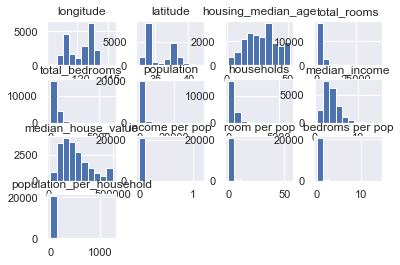

In [301]:
plt.figure(1, dpi=180)
housing.hist()

<Figure size 1200x800 with 0 Axes>

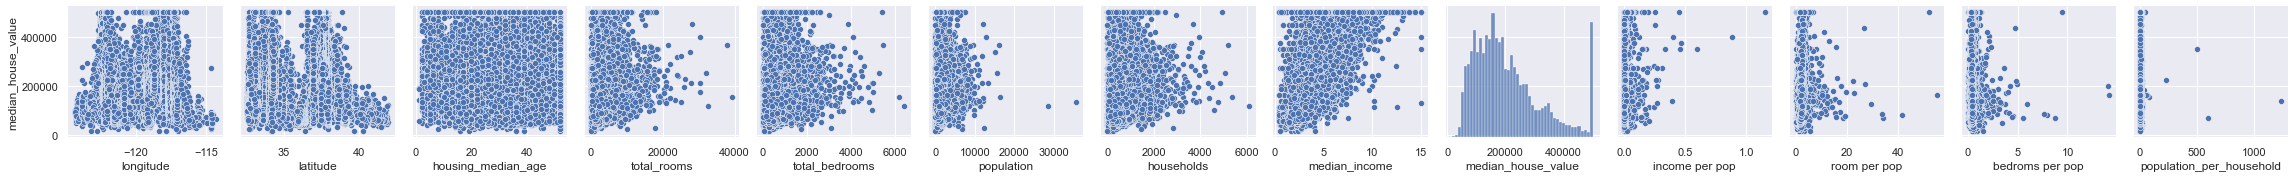

In [302]:
plt.figure(2, dpi=200)
sns.pairplot(data=housing, y_vars='median_house_value')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

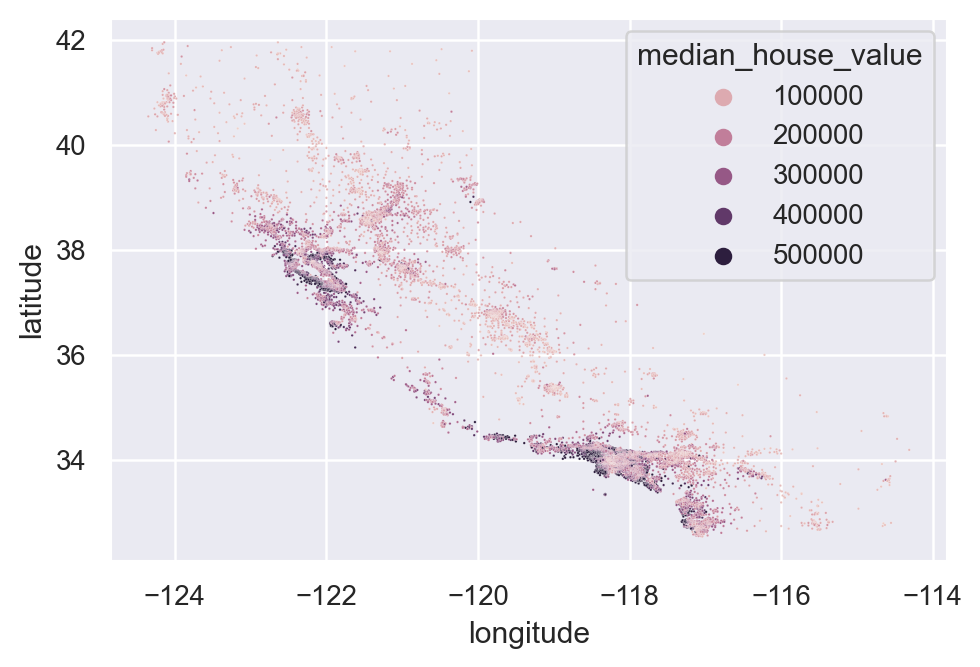

In [303]:
plt.figure(3, dpi=180)
sns.scatterplot(data=housing, x='longitude', y='latitude', hue='median_house_value', s=1)

In [304]:
housing = pd.get_dummies(housing)

describe = get_data_info()
correlations = housing.corr()
scaler = MinMaxScaler()



y = housing.pop('median_house_value')
# scaling
# housing[housing.columns] = scaler.fit_transform(housing[housing.columns])
X = housing


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

#scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   income per pop              20640 non-null  float64
 10  room per pop                20640 non-null  float64
 11  bedroms per pop             20640 non-null  float64
 12  population_per_household    20640 non-null  float64
 13  ocean_proximity_<1H OCEAN   206

In [305]:
'''Neural net'''
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# convert a df to tensor to be used in pytorch

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.unsqueeze(torch.from_numpy(y_train.values).float().to(device), dim=1)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.unsqueeze(torch.from_numpy(y_test.values).float().to(device), dim=1)
X_val = torch.from_numpy(X_val).float().to(device)
y_val = torch.unsqueeze(torch.from_numpy(y_val.values).float().to(device), dim=1)


# store train and val loss
train_loss_list = []
val_loss_list = []
epoch_list = []

n_features = len(housing.columns)
hidden_neurons = 150
hidden_neurons2 = 100
hidden_neurons3 = 50
# network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, hidden_neurons)  # hidden layer
        self.hidden2 = torch.nn.Linear(hidden_neurons, hidden_neurons2)
        self.hidden3 = torch.nn.Linear(hidden_neurons2, hidden_neurons3)
        self.predict = torch.nn.Linear(hidden_neurons3, 1)  # output layer

    def forward(self, x):
        out = F.selu(self.hidden(x)) # activation function for hidden layer
        out = F.selu(self.hidden2(out))
        out = F.selu(self.hidden3(out))
        out = self.predict(out)  # linear output
        return out

def training_loop(n_epochs, optimizer, model, loss_fn, X_train, y_train, X_val, y_val, epoch_num_of_no_improve):
    epoch_no_improve = 0
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0

        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        epoch_list.append(epoch)
        train_loss_list.append(loss_train)

        with torch.no_grad():
            loss_val = 0.0

            outputs = model(X_val)
            loss_v = loss_fn(outputs, y_val)
            loss_val += loss_v.item()

            val_loss_list.append(loss_val)


        # set when to print info about training progress
        if epoch == 1 or epoch % 100 == 0:
            print('Epoch {}, Training loss {:.3f}, Validation loss {:.3f}'.format(epoch,
                                                                          np.sqrt(loss_train),
                                                                          np.sqrt(loss_val)))

        # early stopping
        # early stopping by mean of last x epoch
        ending_point = -epoch_num_of_no_improve-1
        # print(ending_point)
        if epoch > epoch_num_of_no_improve+1:
            last_mean_val_loss =( (sum(val_loss_list[ending_point:-1])) / epoch_num_of_no_improve )
            # print(epoch_num_of_no_improve)
            # print('last ', last_mean_val_loss)
            # print('current' , val_loss_list[-1])
            # print('len', len(val_loss_list[ending_point:-1]))
            if val_loss_list[-1] > last_mean_val_loss:
                print('Early stopping at : \n Epoch {}, Training loss {:.3f}, Validation loss {:.3f}'.format(epoch,
                                                                                  np.sqrt(loss_train),
                                                                                  np.sqrt(loss_val)))
                break
        # early stopping by all of last x epochs
        # if epoch > epoch_num_of_no_improve:
        #     if val_loss_list[-1] >= (sum(val_loss_list[-2:ending_point])/epoch_num_of_no_improve):
        #         epoch_no_improve += 1
        #     else:
        #         epoch_no_improve = 0
        #
        # if epoch_no_improve == 1:
        #     print('Early stopping:')
        #     print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch,
        #                                                                   np.sqrt(loss_train),
        #                                                                   np.sqrt(loss_val)))
        #     break



def validate_on_test(model, loss_fn, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        loss_test = loss_fn(outputs, y_test)

    print('Mean prediction error: {:.3f}'.format(torch.sqrt(loss_test)))

n_epochs = 10000
model = Net().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss() # loss in report is square root of that

# epoch_num_of_no_improve = 5

training_loop(n_epochs=n_epochs,
              optimizer=optimizer,
              model=model,
              loss_fn=loss_fn,
              X_train=X_train,
              y_train=y_train,
              X_val=X_val,
              y_val=y_val,
              epoch_num_of_no_improve=50)

validate_on_test(model=model, loss_fn=loss_fn, X_test=X_test, y_test=y_test)

Using cuda device
Epoch 1, Training loss 238233.052, Validation loss 233582.035
Epoch 100, Training loss 103341.209, Validation loss 102254.321
Epoch 200, Training loss 83638.154, Validation loss 80996.924
Epoch 300, Training loss 69696.283, Validation loss 66720.560
Epoch 400, Training loss 67823.145, Validation loss 65102.335
Epoch 500, Training loss 66503.742, Validation loss 63889.985
Epoch 600, Training loss 65509.540, Validation loss 62937.722
Epoch 700, Training loss 64809.192, Validation loss 62245.822
Epoch 800, Training loss 64208.626, Validation loss 61687.632
Epoch 900, Training loss 63661.459, Validation loss 61182.387
Epoch 1000, Training loss 63180.643, Validation loss 60771.263
Epoch 1100, Training loss 62751.837, Validation loss 60421.892
Epoch 1200, Training loss 62339.450, Validation loss 60071.661
Epoch 1300, Training loss 61956.411, Validation loss 59740.503
Epoch 1400, Training loss 61514.546, Validation loss 59367.969
Epoch 1500, Training loss 60791.564, Validati

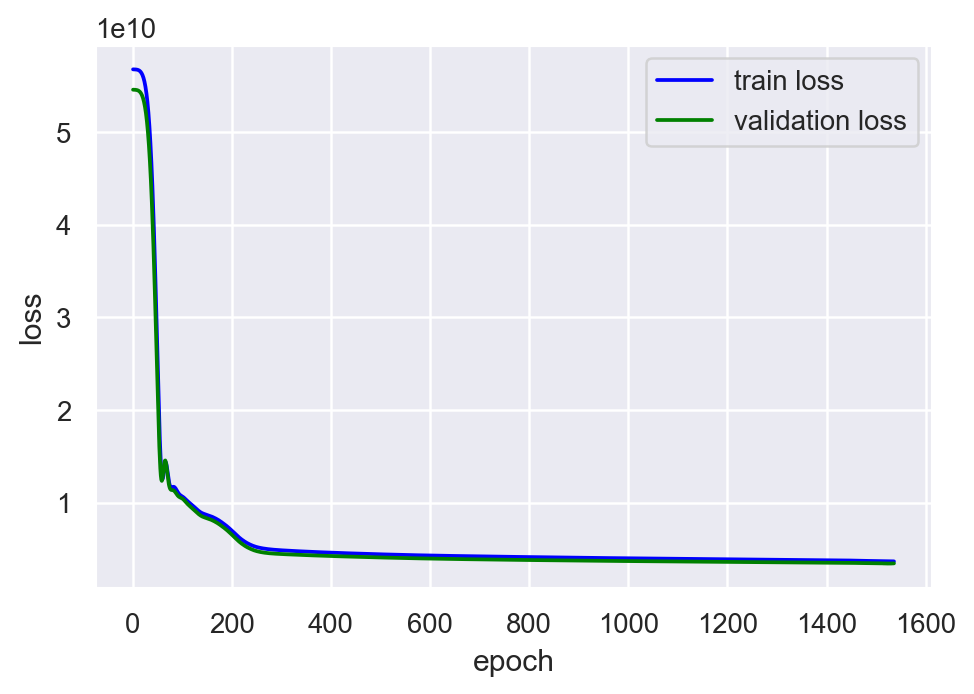

In [306]:
plt.figure(4, dpi=180)
plt.plot(epoch_list, train_loss_list, color='blue', label='train loss')
plt.plot(epoch_list, val_loss_list, color='green', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()